<a href="https://colab.research.google.com/github/Allenlee599/AI_stockRNN/blob/main/StockRNN_108403544.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://i.imgur.com/3twMqGw.png)

# 作業2 : 股票預測

## **請挑選一家公司來做預測**

資料集: [鉅亨網](https://www.cnyes.com/)

> **資料集說明**

別人恐懼我貪婪，一張不賣奇蹟來。

>**作業說明**

**第一步驟**: 左上角 檔案->在雲端硬碟建立副本。

**第二步驟**: 右上角 共用->取得連結->任何知道這個連結的人都能編輯

**第三步驟**: 左上角 執行階段->更變執行類型->GPU。 可以加快模型速度

**第四步驟**: 檔案名稱，請填寫你的學號，把副本上下引號刪掉

請 **隨意修改** 這個colab的程式來完成訓練RNN模型。**不必一定要照著todo提示走。**
繳交時記得改檔案標題的學號。

這次作業的重點在於RNN的維度問題。

> **作業限制**

1. 不要動資料集、不要在訓練時偷看test data
2. 模型請手刻、手疊，**不要用Transfer Learning**，你可以手刻transformer。
3. **不要抄襲**

> **作業繳交**

1. 完成訓練後保存output結果，更改**檔名學號**，左上角 檔案->下載 成ipynb檔。
2. 交一個**pdf**檔，裡面需要附上**你的作業colab連結(設為可編輯、所有人觀看)**、姓名學號年級、過程和執行結果的截圖，並說明你程式撰寫的過程、本次作業心得(字數不限)。
3. 上述三個檔案繳交至ee-class。(Text Generation、Stock、PDF)

> **繳交期限**

1. 電子商務技術(IM5002): 期限至2021/5/16(一) 23:59分
2. 人工智慧與機器學習(IM3078): 期限至2022/5/16(一) 23:59分
3. 電子商務智慧技術(IMA0200): 期限至2022/5/14(六) 23:59分

> **算分標準**

Text Generation(20) + Stock RNN(30) + Predict function(20分) + 30分文件
1.  [Text Generation](https://colab.research.google.com/drive/1bMkAUaiivMaOr8Sd1Ui-KJeoFImEVUqA?usp=sharing) 換個其他資料集來訓練，完成就20分
2. Stock RNN完成模型就30分
3. predit function有寫出來就20分(第七段)
4. 30分是文件分數
5. 記得把以上評分標準截圖、並與你的心得一起貼上pdf

有問題再來信助教: chiachentu@g.ncu.edu.tw(凃家甄)、lufor129@g.ncu.edu.tw(黃智輝)


In [ ]:
# 太多人同時存取可能會報cannot retrieve file error
# 點擊you may still be able to access 下面那個連結再自行上傳檔案即可

import os

if(os.path.isfile("./train.csv") == False or os.path.isfile("./test.csv") == False):
  # !wget -O train.csv "http://140.115.82.54/NN/Recurrent/train.csv"
  # !wget -O test.csv "http://140.115.82.54/NN/Recurrent/test.csv"
  !gdown --id 1iK40K9oXsmhJGs7XSn7q3I1XuPtsZiSj --output "./train.csv"
  !gdown --id 1kZIgeeTnzQf6GJGJuqOe9BgkFa8qb7hJ --output "./test.csv"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1iK40K9oXsmhJGs7XSn7q3I1XuPtsZiSj
To: /content/train.csv
100% 138k/138k [00:00<00:00, 78.3MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1kZIgeeTnzQf6GJGJuqOe9BgkFa8qb7hJ
To: /content/test.csv
100% 2.36k/2.36k [00:00<00:00, 4.16MB/s]


## 1. 讀入Package

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

## 2. 取得資料集

In [ ]:
train_df = pd.read_csv("./train.csv")
train_df = train_df[::-1]
print("company : ",train_df["company"].unique())
train_df.head()

company :  [2317 2454 2330]


,company,date,price
6687,2317,2012/1/2,81.4
6686,2317,2012/1/3,82.7
6685,2317,2012/1/4,83.2
6684,2317,2012/1/5,83.2
6683,2317,2012/1/6,83.9


In [ ]:
test_df = pd.read_csv("./test.csv")
test_df = test_df[::-1]
print("test data shape : ",test_df.shape)
test_df.head()

test data shape :  (117, 3)


,company,date,price
116,2317,2021/2/1,113.0
115,2317,2021/2/2,116.5
114,2317,2021/2/3,116.5
113,2317,2021/2/4,114.0
112,2317,2021/2/5,113.5


In [ ]:
####################################
#                 #
# 自己決定三家公司哪家公司(填數字)#
# 挑選一家公司來做訓練、預測   #
#                 #
#                 #
####################################
companys = {"2330":"TSMC","2454":"MEDIATEK","2317":"FOXCONN"}
company_id = 2330

In [ ]:
company = train_df[train_df["company"] == company_id]
company.index = company["date"]
company.head()

,company,date,price
date,,,
2012/1/2,2330,2012/1/2,75.0
2012/1/3,2330,2012/1/3,75.7
2012/1/4,2330,2012/1/4,75.8
2012/1/5,2330,2012/1/5,76.0
2012/1/6,2330,2012/1/6,75.6


In [ ]:
def include_last_iter(start,end,step):
  i = start
  while i < end:
      yield i
      i += step
  yield end-1

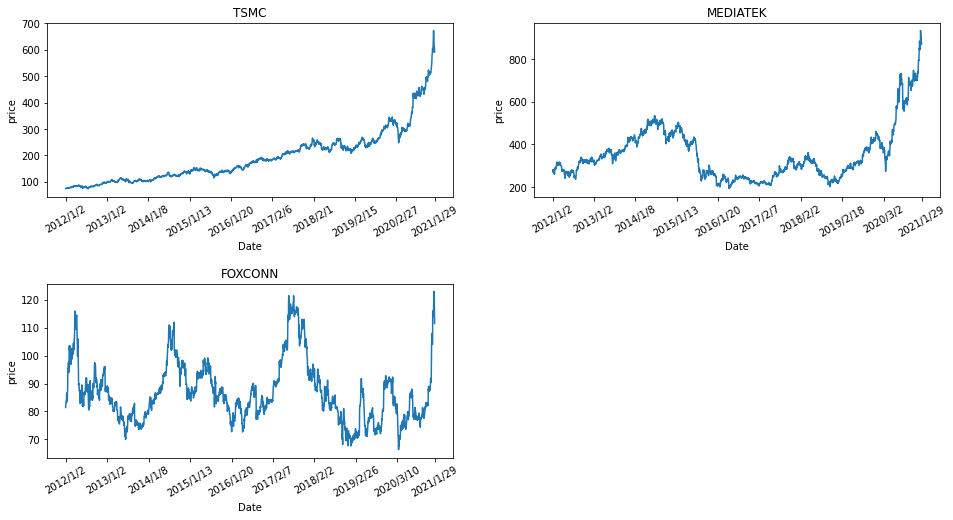

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplots_adjust(hspace=0.5)
for index,c in enumerate(companys):
  plt.subplot(2,2,index+1)
  company_df = train_df[train_df["company"] == int(c)]
  plt.plot(company_df["date"],company_df["price"])
  plt.xticks(list(include_last_iter(0,company_df.shape[0],250)),rotation=30)
  plt.title(companys[c])
  plt.xlabel("Date")
  plt.ylabel("price")
    
plt.show()

## 3. 資料前處理

In [ ]:
# 切分training data & validation data
total_len = company.shape[0]
training_len = 2100
validation_data = total_len - training_len

print("總共有 : ",total_len,"筆")
print("訓練用 : (前)",training_len,"筆")
print("驗證用 : (後)",validation_data,"筆")

總共有 :  2232 筆
訓練用 : (前) 2100 筆
驗證用 : (後) 132 筆


In [ ]:
# 自己做 MinMax Transformer 前處理 
class MinMaxTransformer:
  def __init__(self):
    self.min = None
    self.max = None
    self.distance = None

  def fit(self,data):
    self.min = min(data)
    self.max = max(data)
    self.distance = self.max - self.min
    out = [(d-self.min)/self.distance for d in data]
    return out

  def recover(self,data):
    out = [d*self.distance+self.min for d in data]
    return out

  def transform(self,data):
    out = [(d-self.min)/self.distance for d in data]
    return out

  def transform_one(self,data):
    return (data-self.min)/self.distance

In [ ]:
train_prices = company["price"].values

scalar = MinMaxTransformer()
scalar_data = scalar.fit(train_prices)



In [ ]:
# 做正規化
print("origin data : ",train_prices[:5])
print("transform data : ",scalar_data[:5])
print("recover data : ",scalar.recover(scalar_data[:5]))

origin data :  [75.  75.7 75.8 76.  75.6]
transform data :  [0.00116919993318858, 0.00233839986637716, 0.0025054284282612325, 0.0028394855520294015, 0.002171371304493063]
recover data :  [75.0, 75.7, 75.8, 76.0, 75.6]


In [ ]:
# 切分資料集
training_data = scalar_data[:training_len]
validation_data = scalar_data[training_len:]

In [ ]:
# todo 決定Seq長度
seq_len = 5

def split_input_target(seq):
  input_txt = tf.expand_dims(seq[:-1],-1)
  target_txt = tf.expand_dims(seq[1:],-1)
  return input_txt,target_txt

In [ ]:
def make_ds(data):
  data_slice = tf.data.Dataset.from_tensor_slices(data)
  data_sequence = data_slice.batch(seq_len+1,drop_remainder=True)

  dataset = data_sequence.map(split_input_target)
  return dataset

In [ ]:
# 製作資料集
train_ds = make_ds(training_data)
val_ds = make_ds(validation_data)

for input_example,target_exaple in train_ds.take(1):
  print("Input :", scalar.recover(input_example.numpy()))
  print("Target:", scalar.recover(target_exaple.numpy()))
  print("-"*50)
  print("Input :", input_example.numpy())
  print("Target:", target_exaple.numpy())

Input : [array([75.]), array([75.7]), array([75.8]), array([76.]), array([75.6])]
Target: [array([75.7]), array([75.8]), array([76.]), array([75.6]), array([75.6])]
--------------------------------------------------
Input : [[0.0011692 ]
 [0.0023384 ]
 [0.00250543]
 [0.00283949]
 [0.00217137]]
Target: [[0.0023384 ]
 [0.00250543]
 [0.00283949]
 [0.00217137]
 [0.00217137]]


In [ ]:
# Batch size
# todo 決定Batch大小
BATCH_SIZE = 8

BUFFER_SIZE = training_len

train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)

## 4. 建立模型

提示: Output是一個數值，所以Model output維度為1。

* 輸入維度應為: (batch,seq_len,1)

* 輸出維度應為: (batch,seq_len,1)

**最後一層Dense不要加上任何activation function。**


In [ ]:
# todo
input_shape = (5,1)
#不用加batch，因為前面batch在前面已經加入了
model = tf.keras.Sequential()
#model.add(tf.keras.layers.Embedding(8,5))
model.add(
  tf.keras.layers.LSTM(
    units=50,
    input_shape = (5,1),
    return_sequences=True,
))
model.add(Dropout(0.2))
model.add(
  tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 dense (Dense)               (None, 5, 1)              51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


## 5. 制定訓練計畫並訓練

我們做數字相關預測，可以考慮用Mean_Squared_Error

公式:
$$MSE = \frac{1}{n} \sum_{i=1}^N({\gamma-\hat{\gamma}})^2$$


提示:
不用管公式在幹嘛，compile帶入mean_squared_error。

In [ ]:
# todo
epochs = 200

# todo
# model.compile
model.compile(optimizer='adam',loss='mean_squared_error')
# todo
# model.fit
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs,batch_size=8)

Epoch 1/200
44/44 [==============================] - 3s 19ms/step - loss: 1.0003e-04 - val_loss: 2.1868e-04
Epoch 2/200
44/44 [==============================] - 0s 6ms/step - loss: 1.0453e-04 - val_loss: 3.0363e-04
Epoch 3/200
44/44 [==============================] - 0s 7ms/step - loss: 1.0402e-04 - val_loss: 2.4913e-04
Epoch 4/200
44/44 [==============================] - 0s 6ms/step - loss: 1.0344e-04 - val_loss: 2.7520e-04
Epoch 5/200
44/44 [==============================] - 0s 7ms/step - loss: 9.9626e-05 - val_loss: 2.2837e-04
Epoch 6/200
44/44 [==============================] - 0s 7ms/step - loss: 9.5845e-05 - val_loss: 2.2723e-04
Epoch 7/200
44/44 [==============================] - 0s 7ms/step - loss: 1.0317e-04 - val_loss: 2.3352e-04
Epoch 8/200
44/44 [==============================] - 0s 7ms/step - loss: 1.0652e-04 - val_loss: 2.4854e-04
Epoch 9/200
44/44 [==============================] - 0s 7ms/step - loss: 9.7445e-05 - val_loss: 2.4325e-04
Epoch 10/200
44/44 [================

## 6. 評估模型

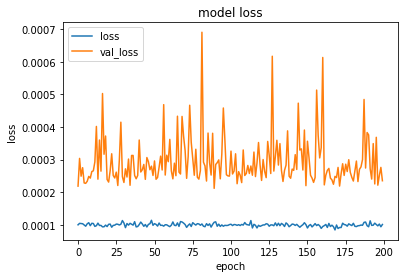

In [ ]:
l1, = plt.plot(history.history['loss'])
l2, = plt.plot(history.history['val_loss'])
plt.legend(handles=[l1,l2],labels=['loss','val_loss'],loc='best')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [ ]:
test_company = test_df[test_df["company"] == company_id]
test_company.head()

,company,date,price
38,2330,2021/2/1,611.0
37,2330,2021/2/2,632.0
36,2330,2021/2/3,630.0
35,2330,2021/2/4,627.0
34,2330,2021/2/5,632.0


## 7. 做預測 (20分)

In [ ]:
# 預測 Test data
# 現在我們取出了選定公司最後seq_len天
# 我們模型透過讀取seq_len天後預測出seq_len+1天的價格

# 將日期保存在datas中 (list)
# 將真實價格保存在real_prices中 (list)
# 將預測價格保存在pred_prices中 (list) *注: 請填入經過正規化後的價格

# input是一個經過**正規化**的真實價格list，請試著遍歷test_company來填滿上述三個list
# 可以參考TextGeneration的generateWords function，概念一樣，但是這次input請全部都填入"真實價格"
# 但是這次input請append "真實價格"
# 但是這次input請append "真實價格"
# 但是這次input請append "真實價格"
# 但是這次input請append "真實價格"
# 但是這次input請append "真實價格"

init_price = company.iloc[-seq_len:,:]["price"].values
dates = []
real_prices = []
pred_prices = []
input = scalar.transform(init_price)#input為company price經過minmax號介於0跟1的值


for index,row in test_company.iterrows():
  # 我已經幫你把real_price和date放入list
  real_price = row["price"]
  real_prices.append(real_price)
  date = row["date"]
  dates.append(date)

  
  
  # 參考步驟 (在for迴圈中) :
  # 1. 把input轉**維度**成一個新變數next_input丟入model
  next_input = tf.expand_dims(input,axis=1)
  pred = model(next_input)
  # 2. 獲得的pred取出seq中最後一個時間點的output數值 (提示: [0,-1,0])
  pred = pred[0,-1,0]
  # 3. 把pred丟入pred_prices中
  pred_prices.append(pred.numpy())
  # 4. 把real_price經過transform_one轉換成小數點並加在input後面
  transform_one_real_price = scalar.transform_one(real_price)
  input.append(transform_one_real_price)
  # 5. 保持input長度為seq_len長 (也就是把最前面的數字踢掉)
  input.pop(0)




In [ ]:
print(f"dates : {dates[:10]}")
print(f"real_prices : {real_prices[:10]}")
print(f"pred_prices : {pred_prices[:10]}")

dates : ['2021/2/1', '2021/2/2', '2021/2/3', '2021/2/4', '2021/2/5', '2021/2/17', '2021/2/18', '2021/2/19', '2021/2/22', '2021/2/23']
real_prices : [611.0, 632.0, 630.0, 627.0, 632.0, 663.0, 660.0, 652.0, 650.0, 641.0]
pred_prices : [0.9269497, 0.90092564, 0.8976681, 0.874839, 0.8585042, 0.89115036, 0.92532516, 0.92207515, 0.9171983, 0.92532516]


* 預期結果:

![](https://i.imgur.com/iXdMWD6.png)

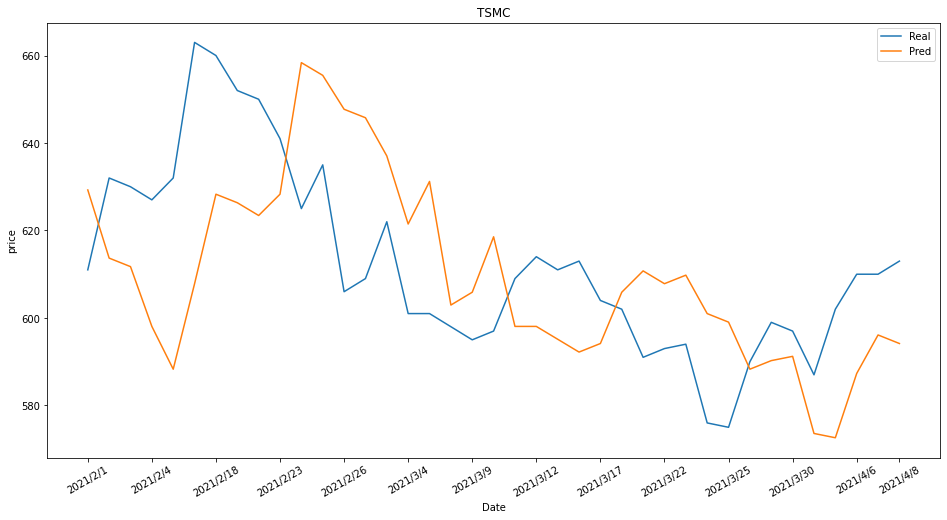

In [ ]:
plt.figure(figsize=(16, 8))
l1, = plt.plot(dates,real_prices)
l2, = plt.plot(dates,scalar.recover(pred_prices))
plt.xticks(list(include_last_iter(0,len(dates),3)),rotation=30)
plt.legend(handles=[l1,l2],labels=['Real','Pred'],loc='best')
plt.title(companys[str(company_id)])
plt.xlabel("Date")
plt.ylabel("price")
plt.show()

* 預期成果

照理來說不會100%猜中，猜中幾乎100%可能是不小心偷看答案了。

不過要是你的模型正確的話，應該會看到如下pred price在true price附近而不是躺在地上。

![](https://i.imgur.com/tFoKEyK.png)